In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

Using backend: tensorflow.compat.v1

2023-07-31 22:09:05.149426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-07-31 22:09:48.287935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 22:09:50.525551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 22:09:50.526242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
n = 3
l = 2
m = 0
Z = 1
r_max = 50

In [3]:
num_dense_nodes = 50
num_dense_layers = 7

In [4]:
def azimuth_part(phi):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(phi * m * 1j)

In [5]:
def polar_part(theta):
    # 2*pi is already at the z_component
    normalization_constant = ((-1) ** m) * np.sqrt(((2 * l + 1) / 2) * (np.math.factorial(l - m) / np.math.factorial(l + m)))
    legendre_values = []
    for i in theta:
        legendre_polynomials, _ = sp.lpmn(m, l, np.cos(i[0]))
        legendre = legendre_polynomials[m, l]
        legendre_values.append([legendre])
    legendre_values = np.array(legendre_values)
    
    return normalization_constant * legendre_values

In [6]:
def radial_part(r):
    normalization_constant = np.sqrt(
        np.power(2.0 / n, 3.0) * (np.math.factorial(n - l - 1) / (2 * n * np.math.factorial(n + l)))
    )
    
    exponent = np.exp(- (Z * r) / n)
    power = np.power(2 * Z * r / n, l)
    laguerre_polynomial = sp.genlaguerre(n - l - 1, 2 * l + 1)
    laguerre_value = laguerre_polynomial(2 * Z * r / n)
    
    return normalization_constant * exponent * power * laguerre_value

In [7]:
def pde(x, y):
    dy_r = dde.grad.jacobian(y, x, i=0, j=0)
    dy_rr = dde.grad.hessian(y, x, i=0, j=0)
    
    E = (Z ** 2) / (2 * (n ** 2))
    hessian_part = - ((x ** 2) / 2) * dy_rr
    jacobian_part = - x * dy_r
    y_part = 0.5 * l * (l + 1) * y - Z * x * y - E * (x ** 2) * y
    
    return hessian_part * jacobian_part * y_part

In [8]:
domain = dde.geometry.Interval(0, r_max)

In [9]:
def get_collocation_points(n):
    r_values = []
    
    r_interval = r_max / (4 * n)
    
    for k in range(3 * n - 1):
        r = (k + 1) * r_interval
        r_values.append(r)
    
    return np.array(r_values).reshape((3 * n - 1, 1))

In [10]:
collocation_points = get_collocation_points(n)
collocation_values = radial_part(collocation_points)

collocation_values

array([[0.03903059],
       [0.03892945],
       [0.02184108],
       [0.00968199],
       [0.00377223],
       [0.00135448],
       [0.00045971],
       [0.00014972]])

In [11]:
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)

In [12]:
def boundary(x, on_boundary):
    return on_boundary and np.isclose(x, r_max)[0]

In [22]:
def boundary_value(x):
    print(x)
    return 0

In [23]:
dirichlet_bc = dde.icbc.DirichletBC(domain, boundary_value, boundary)

In [24]:
bcs = [ic, dirichlet_bc]

In [29]:
num_train = 64
num_test = 100

# for some reason DeepXDE needs at least 2 boundary points
# even though that only 1 is essential here
num_boundary = 2

In [30]:
data = dde.data.PDE(
    domain,
    pde,
    bcs,
    num_domain=num_train,
    num_boundary=num_boundary,
    solution=radial_part,
    num_test=num_test
)

In [31]:
activation = 'tanh'
initializer = 'Glorot uniform'

net = dde.nn.FNN(
    [1] + [num_dense_nodes] * num_dense_layers + [1],
    activation,
    initializer
)

In [32]:
loss_weights = [1, 100, 100]

model = dde.Model(data, net)
model.compile(
    'L-BFGS',
    metrics=['l2 relative error'],
    loss_weights=loss_weights
)

Compiling model...
Building feed-forward neural network...
'build' took 0.123484 s



2023-07-31 22:17:21.027067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 22:17:21.027399: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-31 22:17:21.027638: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[[50.]]
[[50.]]
'compile' took 0.897261 s



In [33]:
loss_history, train_state = model.train(iterations=20000)

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [6.21e-03, 4.52e+00, 1.32e+00]    [6.46e-03, 4.52e+00, 1.32e+00]    [1.09e+01]    
1000      [3.18e-08, 1.25e-04, 2.77e-06]    [3.31e-08, 1.25e-04, 2.77e-06]    [2.35e-01]    
2000      [3.90e-08, 2.61e-05, 5.54e-07]    [4.06e-08, 2.61e-05, 5.54e-07]    [1.33e-01]    
3000      [4.51e-08, 2.29e-06, 1.85e-08]    [4.69e-08, 2.29e-06, 1.85e-08]    [1.05e-01]    
4000      [4.60e-08, 1.17e-06, 5.67e-09]    [4.79e-08, 1.17e-06, 5.67e-09]    [1.09e-01]    
5000      [4.51e-08, 2.11e-06, 3.66e-08]    [4.70e-08, 2.11e-06, 3.66e-08]    [1.21e-01]    
6000      [4.67e-08, 1.16e-06, 3.54e-09]    [4.86e-08, 1.16e-06, 3.54e-09]    [1.28e-01]    
7000      [4.58e-08, 2.19e-06, 2.86e-08]    [4.77e-08, 2.19e-06, 2.86e-08]    [1.33e-01]    
8000      [4.69e-08, 1.58e-06, 5.66e-09]    [4.88e-08, 1.58e-06, 5.66e-09]    [1.31e-01]    
9000      [4.66e-08, 2.03

Saving loss history to /home/piotr/repos/quant-chem-pinns/hydrogen-atom/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/hydrogen-atom/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/hydrogen-atom/test.dat ...


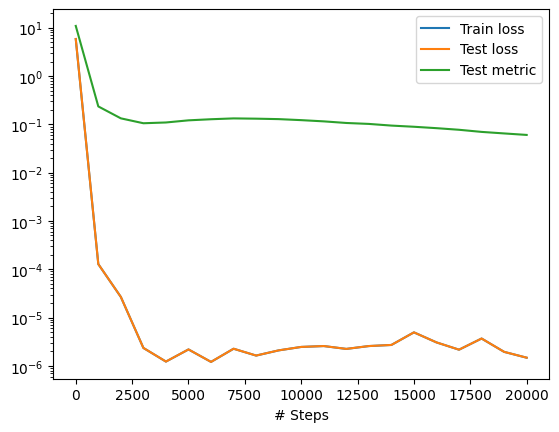

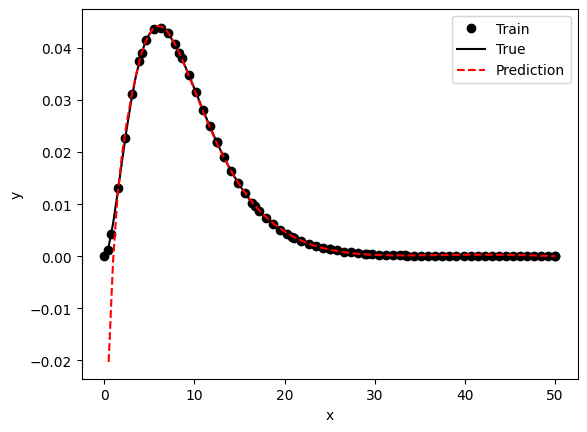

In [34]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [35]:
def plot_radial_distribution(grid_dist=0.1):
    r_values = np.arange(0, r_max, grid_dist)
    
    true_values = np.power(r_values, 2) * np.power(radial_part(r_values), 2)
    predicted_values = np.power(model.predict(np.reshape(np.copy(r_values), (r_values.shape[0], 1))), 2)
    predicted_values = predicted_values.squeeze()
    predicted_values = np.power(r_values, 2) * predicted_values
    
    plt.plot(r_values, true_values, 'b-', label='true')
    plt.plot(r_values, predicted_values, 'r--', label='predicted')
    
    plt.legend()

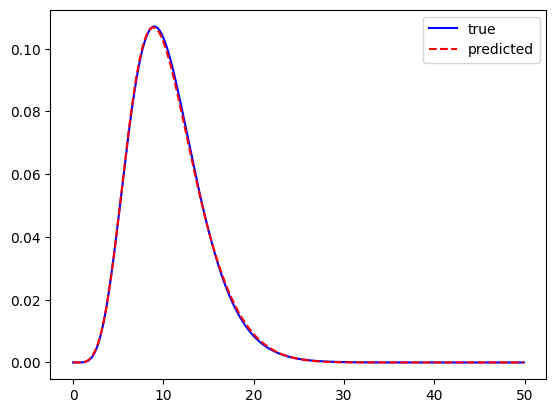

In [36]:
plot_radial_distribution()